In [237]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from skmultiflow.data import RegressionGenerator
from skmultiflow.meta import AdaptiveRandomForestRegressor
from skmultiflow.data.file_stream import FileStream
from skmultiflow.evaluation import EvaluatePrequential
from skmultiflow.drift_detection.adwin import ADWIN
from skmultiflow.drift_detection.eddm import EDDM
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL, DecomposeResult
import ruptures as rpt
import changefinder as cf
import statistics as stats
import datetime
import copy
import bnlearn
from scipy.stats import hypergeom
import seaborn as sns
import pgmpy
#%matplotlib

In [2]:
#Adaptive random forest
#Adaptive XGBoost

In [3]:
directory='data/'
#data = np.load(directory+'incident_nyc.npy', allow_pickle=True)
data = pd.read_csv(directory+'incident_nyc.csv')

In [4]:
isCrash =  [
     'Accident',
     'Accident Road Closed',
     'Accident investigation',
     'Accident with Injuries',
     'Accident with Property Damage',
     'Crash',
     'Crash investigation',
     'Crash with Injuries',
     'Crash with Property Damage'
     
 ]
isDebris = ['Debris spill','Missing Sewer Grate','Gas main break','Roadway non-hazmat spill','Watermain break', 'Falling Debris','Downed pole','Collapsed Sewer Grate','Collapsed Scaffolding','Collapsed Manhole','Fuel spill','Nearby building collapse','Sinkhole','Road Collapse','Steam leak','Downed wires','Fluid Spill','Cargo spill','Hazmat spill','Sewer main break']
isDisabled = ['Disabled vehicle','Vehicle fire','Overturned vehicle','Disabled truck','Disabled bus','Disabled tractor trailer','Misplaced commercial vehicle','Misplaced tractor trailer','Overturned Truck','Overturned tractor trailer','Overheight tractor trailer','Truck fire','Misplaced bus','Jack-knifed tractor trailer','Tractor trailer fire','Bus fire','Vehicle off the roadway','Overturned Dump Truck','Equipment malfunction']
isPolice = ['EMS activity','Fire department activity','Police department activity']
#isPolice = ['Police department activity']
isConstruct = ['Emergency construction']

In [5]:
data=data.sort_values(by=['Start Date Time'], ignore_index=True)
data['Start Date Time'] = pd.to_datetime(data['Start Date Time'])
#data = data[(data['Duration (min)']>=5) & (data['Duration (min)']<=60)]
data = data.loc[(data['Duration (min)']>=5)]

quantile=0.95
data = data[data['Duration (min)'] < data['Duration (min)'].quantile(quantile)]

data_crash = data[data['Incident Type']==0]
data_debris = data[data['Incident Type']==1]
data_disable = data[data['Incident Type']==2]
data_police = data[data['Incident Type']==3]
data_construct = data[data['Incident Type']==4]


#data = data[data['Year']>=2019]
DurationsByFreq = data.groupby(pd.Grouper(key='Start Date Time', axis=0, freq='1M', sort=True))['Duration (min)']

In [6]:
years = sorted(list(set(data['Year'])))
# data[data['Year']==2015]['Duration (min)'].max()
# data_police[data_police['Year']==2015]['Duration (min)'].var()
for year in years:
    print(data_police[data_police['Year']==year]['Duration (min)'].std())

40.56174780030298
46.394634394246424
46.75163322147041
39.98682423926383
47.09410364551517
40.45211138326258
50.03541255389179


In [7]:
def timeseries_analysis_mean(data, type_='all', freq='1M', quantile=1.00):
    if type_=='all':
        Dat = data
    elif type_=='Crash':
        Dat = data[data['Event Type'].str.contains('|'.join(isCrash))]
    elif type_ == 'Debris':
        Dat = data[data['Event Type'].str.contains('|'.join(isDebris))]
    elif type_ == 'Disabled':
        Dat = data[data['Event Type'].str.contains('|'.join(isDisabled))]
    elif type_ == 'Police':
        Dat = data[data['Event Type'].str.contains('|'.join(isPolice))]
    elif type_ == 'Construct':
        Dat = data[data['Event Type'].str.contains('|'.join(isConstruct))]
    else:
        Dat = data[data['Event Type']==type_]
    Dat = Dat[Dat['Duration (min)'] < Dat['Duration (min)'].quantile(quantile)]
    DurationsByFreq = Dat.groupby(pd.Grouper(key='Start Date Time', axis=0, freq=freq, sort=True))['Duration (min)']
    DurationsByFreqFil = DurationsByFreq.apply(lambda x: x[(x<=x.quantile(0.95)) & (x>=x.quantile(0.05))])
    ax = plt.subplot(111)
    ax.bar(DurationsByFreq.groups.keys(), DurationsByFreq.quantile(0.95), width=10, color='blue',alpha=0.5)
    ax.bar(DurationsByFreq.groups.keys(), DurationsByFreq.quantile(0.05), width=10, color='red',alpha=0.5)
    ax.set_ylabel('Monthly duration 95% (red) and 5% (blue) value '+type_)
#     ax.xaxis_date()
    ax2 = ax.twinx()
    ax2.plot_date(DurationsByFreq.groups.keys(), DurationsByFreq.mean(), '-b', color="black",linewidth=1)
    ax2.plot_date(DurationsByFreq.groups.keys(), DurationsByFreq.mean(), color="red")
#     ax2.set_ylim(30, max(DurationsByFreq.mean())+50)
    ax2.set_ylabel('Monthly average duration of '+type_+' (minutes)')
#     ax2.xaxis_date()
    plt.setp(ax.xaxis.get_majorticklabels(),'rotation', 90)
    plt.setp(ax2.xaxis.get_majorticklabels(),'rotation', 90)
    plt.show()
    return DurationsByFreq

In [227]:
def timeseries_analysis_mean_only(data, type_='all', freq='1M', quantile=1.00):
    if type_=='all':
        Dat = data
    elif type_=='Crash':
        Dat = data[data['Event Type'].str.contains('|'.join(isCrash))]
    elif type_ == 'Debris':
        Dat = data[data['Event Type'].str.contains('|'.join(isDebris))]
    elif type_ == 'Disabled Vehicle':
        Dat = data[data['Event Type'].str.contains('|'.join(isDisabled))]
    elif type_ == 'Response Team Activities':
        Dat = data[data['Event Type'].str.contains('|'.join(isPolice))]
    elif type_ == 'Construct':
        Dat = data[data['Event Type'].str.contains('|'.join(isConstruct))]
    else:
        Dat = data[data['Event Type']==type_]
    Dat = Dat[Dat['Duration (min)'] < Dat['Duration (min)'].quantile(quantile)]
    DurationsByFreq = Dat.groupby(pd.Grouper(key='Start Date Time', axis=0, freq=freq, sort=True))['Duration (min)']
    DurationsByFreqFil = DurationsByFreq.apply(lambda x: x[(x<=x.quantile(0.95)) & (x>=x.quantile(0.05))])
    ax = plt.subplot(111)
#     ax.bar(DurationsByFreq.groups.keys(), DurationsByFreq.quantile(0.95), width=10, color='blue',alpha=0.5)
#     ax.bar(DurationsByFreq.groups.keys(), DurationsByFreq.quantile(0.05), width=10, color='red',alpha=0.5)
#     ax.set_ylabel('Monthly duration 95% (red) and 5% (blue) value '+type_)
    ax.xaxis_date()
    #ax2 = ax.twinx()
    ax.plot_date(DurationsByFreq.groups.keys(), DurationsByFreq.mean(), '-b', color="black",linewidth=1)
    ax.plot_date(DurationsByFreq.groups.keys(), DurationsByFreq.mean(), color="red")
#     ax2 = ax.twinx()
#     ax2.plot_date(DurationsByFreq.groups.keys(), DurationsByFreq.count(), '-b', color="black",linewidth=1)
#     ax2.plot_date(DurationsByFreq.groups.keys(), DurationsByFreq.count(), color="blue")
#     ax2.set_ylim(30, max(DurationsByFreq.mean())+50)
    ax.set_ylabel('Monthly average duration of '+type_+' (minutes)')
    plt.axvline(x=list(DurationsByFreq.groups.keys())[-23],color='green', linewidth=1, linestyle='--')
    ax.xaxis_date()
    plt.setp(ax.xaxis.get_majorticklabels(),'rotation', 90)
    #plt.setp(ax2.xaxis.get_majorticklabels(),'rotation', 90)
    plt.savefig('Monthly average TID of '+type_+' (minutes).png', dpi=300)
    plt.show()
   
    return DurationsByFreq

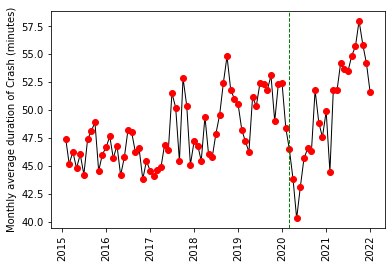

In [229]:
timeseries_analysis_mean_only(data, 'Crash',quantile=1)

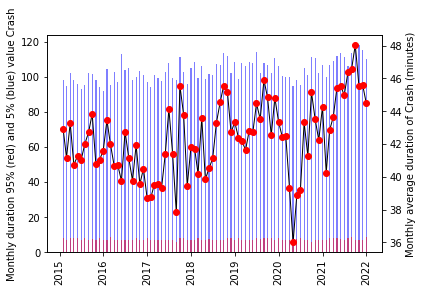

In [10]:
timeseries_analysis_mean(data, 'Crash',quantile=0.95)

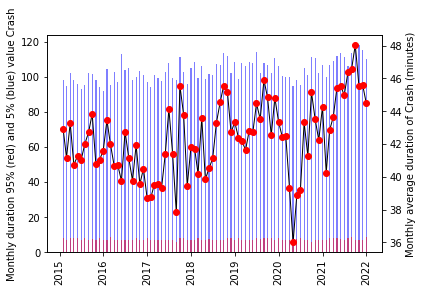

In [11]:
a = timeseries_analysis_mean(data, 'Crash','1M',quantile=0.95)

In [12]:
data['County'].unique()
input_data = copy.deepcopy(data)

In [13]:
data['Year'].unique()

array([2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [14]:
for index, row in data.iterrows():
    if row['Direction'] in ['all directions','both directions']:
        input_data['Direction'][index] = 0
    if row['Direction'] == 'eastbound':
        input_data['Direction'][index] = 1 
    if row['Direction'] == 'westbound':
        input_data['Direction'][index] = 2
    if row['Direction'] == 'southbound':
        input_data['Direction'][index] = 3 
    if row['Direction'] == 'northbound':
        input_data['Direction'][index] = 4
#     else:
#         input_data['Direction'][index] = 5

In [15]:
for index, row in data.iterrows():
    if row['County'] == 'New York':
        input_data['County'][index] = 0
    if row['County'] == 'Kings':
        input_data['County'][index] = 1 
    if row['County'] == 'Queens':
        input_data['County'][index] = 2
    if row['County'] == 'Bronx':
        input_data['County'][index] = 3 
    if row['County'] == 'Richmond':
        input_data['County'][index] = 4

In [16]:
for index, row in data.iterrows():
    if row['Year'] == 2015:
        input_data['Year'][index] = 0
    if row['Year'] == 2016:
        input_data['Year'][index] = 1
    if row['Year'] == 2017:
        input_data['Year'][index] = 2
    if row['Year'] == 2018:
        input_data['Year'][index] = 3
    if row['Year'] == 2019:
        input_data['Year'][index] = 4
    if row['Year'] == 2020:
        input_data['Year'][index] = 5
    if row['Year'] == 2021:
        input_data['Year'][index] = 6

In [17]:
input_data.columns
input_data = input_data[['Incident Type', 'Direction', 'County', 'Start Date Time',
       'Duration (min)', 'Year', 'Lane Closure Type', 'TOD', 'PeakHour',
       'DayofWeek', 'MonthofYear', 'Injury involved', 'Truck involved',
       'Fire involved']]

In [18]:
input_data_crash = input_data[input_data['Incident Type']==0]
input_data_debris = input_data[input_data['Incident Type']==1]
input_data_disable = input_data[input_data['Incident Type']==2]
input_data_police = input_data[input_data['Incident Type']==3]
input_data_construct = input_data[input_data['Incident Type']==4]

In [19]:
# input_data_crash.to_csv('crash_nyc.csv', index_label=False)
# input_data_disable.to_csv('disable_nyc.csv', index_label=False)

# Drift Detection

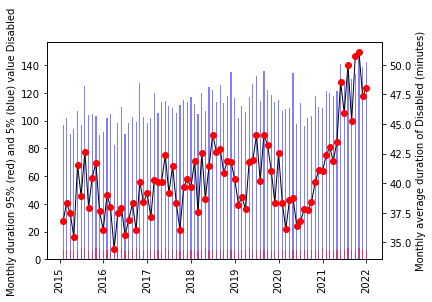

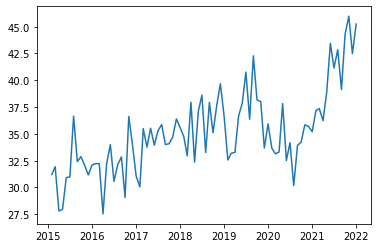

In [319]:
DurationsByFreq = timeseries_analysis_mean(data, 'Disabled','1M',quantile=1)
DurationsByFreq.var()
plt.plot(DurationsByFreq.std())

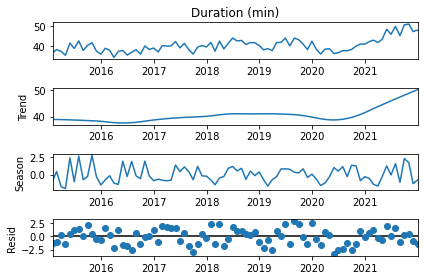

In [320]:
stl = STL(DurationsByFreq.mean())
res = stl.fit()
fig = res.plot()
#fig.savefig('STL_Police.png', dpi=300)

Start Date Time
2015-01-31    38.933408
2015-02-28    38.907585
2015-03-31    38.871926
2015-04-30    38.826809
2015-05-31    38.772932
                ...    
2021-08-31    47.420169
2021-09-30    48.132999
2021-10-31    48.839800
2021-11-30    49.539837
2021-12-31    50.232360
Freq: M, Name: trend, Length: 84, dtype: float64

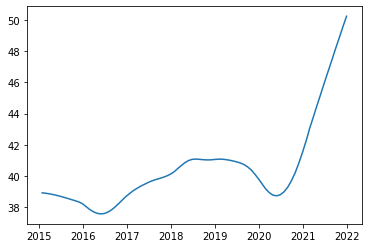

In [321]:
plt.plot(res.trend)
res.trend

In [205]:
def s_strength(season, resid):
    F_T = max(0, 1-(stats.variance(resid)/stats.variance(season+resid)))
    
    return F_T

def t_strength(trend, resid):
    F_T = max(0, 1-(stats.variance(resid)/stats.variance(trend+resid)))
    
    return F_T


In [206]:
for i in range(1,8):
    print(s_strength(res.seasonal[(i-1)*12:i*12],res.resid[(i-1)*12:i*12]))

0.631573808445387
0.5516814085857173
0.4950447578721503
0.6209379072571657
0.4756590247906354
0.3950483071729739
0.6124639654467428


In [207]:
for i in range(1,8):
    print(t_strength(res.trend[(i-1)*12:i*12],res.resid[(i-1)*12:i*12]))

0.2736490641230802
0.2077373907497886
0.1103714933200225
0.2523284901652133
0
0.34609788092454863
0.25712810802580754


In [60]:
adwin = ADWIN(delta=5)
eddm = EDDM()
for i in range(len(DurationsByFreq.groups.keys())):
    adwin.add_element(DurationsByFreq.mean()[i])
    eddm.add_element(DurationsByFreq.mean()[i])
    if adwin.detected_change():
        print('Change detected in data: ' + str(DurationsByFreq.mean()[i]) + ' - at index: ' + str(i))
#adwin.get_info()
#eddm.detected_change()

Change detected in data: 35.69341894060995 - at index: 31
Change detected in data: 33.56024096385542 - at index: 63


/opt/anaconda3/lib/python3.8/site-packages/skmultiflow/drift_detection/adwin.py:361: RuntimeWarning: invalid value encountered in sqrt
  epsilon = np.sqrt(2 * m * v * dd) + 1. * 2 / 3 * dd * m


In [43]:
adwin = ADWIN(0.09)
for index, row in data.iterrows():
    adwin.add_element(row['Duration (min)'])
    if adwin.detected_change():
        print('Change detected in data: ' + str(row['Duration (min)']) + ' - at index: ' + str(row['Start Date Time']))

Change detected in data: 116.0 - at index: 2015-09-26 00:21:00
Change detected in data: 7.0 - at index: 2018-11-11 12:17:15
Change detected in data: 49.0 - at index: 2019-10-11 22:59:11
Change detected in data: 7.0 - at index: 2019-11-24 08:19:15
Change detected in data: 4.0 - at index: 2020-01-04 20:28:00
Change detected in data: 34.0 - at index: 2020-05-28 17:49:04
Change detected in data: 41.0 - at index: 2020-11-27 15:51:20
Change detected in data: 114.0 - at index: 2021-05-18 14:36:05
Change detected in data: 120.0 - at index: 2021-06-24 16:39:47
Change detected in data: 22.0 - at index: 2021-07-19 16:41:40
Change detected in data: 135.0 - at index: 2021-09-24 11:50:50
Change detected in data: 47.0 - at index: 2021-10-21 05:33:18
Change detected in data: 20.0 - at index: 2021-12-12 08:15:52


In [134]:
data.columns
column = ['Facility','Incident Type', 'Direction','County', 'Year', 'Lane Closure Type', 'TOD', 'PeakHour',
       'DayofWeek', 'MonthofYear', 'Injury involved', 'Truck involved',
       'Fire involved',  'Duration (min)','Recovery (min)']
cat_col = ['Facility', 'Direction','County','Year']
data = data[column]

In [6]:
#Encode categorical variables:
for col in cat_col:
    data[col] = LabelEncoder().fit_transform(data[col])
#year
# le = LabelEncoder()
# le.fit(data['Year'])
# data['Year'] = le.transform(data['Year'])
# le_year_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

In [220]:
data['County'].unique()

array(['New York', 'Queens', 'Bronx', 'Kings', 'Richmond'], dtype=object)

# Change point detection

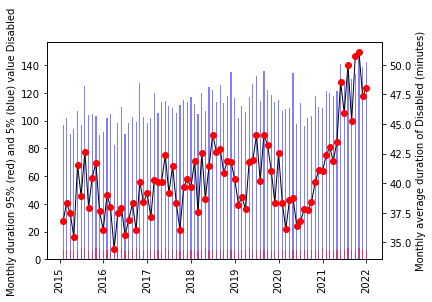

In [322]:
DurationsByFreq = timeseries_analysis_mean(data, 'Disabled','1M',quantile=1)
duration_arr = np.asarray(DurationsByFreq.mean())
duration_idx = DurationsByFreq.mean().index


[25, 40, 60, 70, 75, 84]

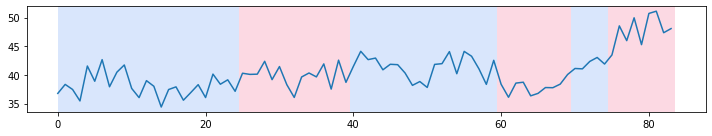

In [326]:
#Changepoint detection with the Pelt search method
model="rbf"
algo=rpt.Pelt(model=model,min_size=3).fit(duration_arr)
result=algo.predict(pen=1) #pen for crash: 0.7, pen for disable: 1
x = DurationsByFreq.mean().index
# x = [datetime.date(2020,3,1), datetime.date(2020,6,25)]
# rpt.display(volume_points,result,[22,100,114], figsize=(20,6))
rpt.display(duration_arr, result)
#rpt.display(duration_arr,x, result, figsize=(10,6))
# date = pd.date_range(start="2020/03/01",end="2020/06/30", periods=7)
# plt.xticks(np.arange(0,121,20), date.date, rotation=20)
# plt.title('Change Point Detection: Pelt Search Method')
# plt.show()
result


In [327]:
DurationsByFreq.groups.keys()
datelist = list(DurationsByFreq.groups.keys())
datelist[1]

Timestamp('2015-02-28 00:00:00', freq='M')

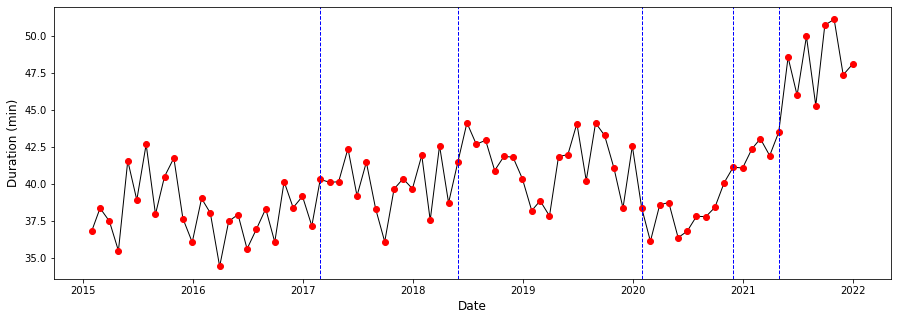

In [328]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
#ax = plt.subplot(111)
ax.plot_date(DurationsByFreq.groups.keys(), DurationsByFreq.mean(), '-b', color="black",linewidth=1)
ax.plot_date(DurationsByFreq.groups.keys(), DurationsByFreq.mean(), color="red")
ax.set_ylabel('Duration (min)', fontsize=12)
ax.set_xlabel('Date',fontsize=12)
xcoords = result
for xc in xcoords[:-1]:
    plt.axvline(x=datelist[xc],color='blue', linewidth=1, linestyle='--')
#fig.savefig('CPD result for disable.png', dpi=300)

In [329]:
dir = 'Result/'
vol = pd.read_excel(dir+'Incident Duration Statistics.xlsx', sheet_name='BTVolume')
vol=vol.rename(columns={'Unnamed: 0':'Year'})
vol_list = []
for index, row in vol.iterrows():
    vol_list.append(row[1:])
vol_list = pd.concat(vol_list, axis=0)
vol_df = pd.DataFrame({'date': datelist, 'Volume': vol_list})

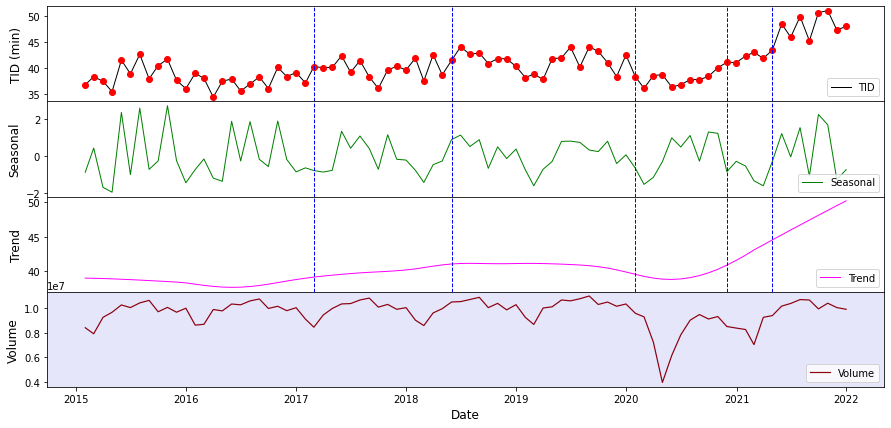

In [330]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(15, 7), sharex=True, gridspec_kw={'wspace': 0})
ax1.plot_date(DurationsByFreq.groups.keys(), DurationsByFreq.mean(), '-b', color="black",linewidth=1, label='TID')
ax1.plot_date(DurationsByFreq.groups.keys(), DurationsByFreq.mean(), color="red")
ax2.plot_date(DurationsByFreq.groups.keys(), res.seasonal, '-b', color="green",linewidth=1, label='Seasonal')
ax3.plot_date(DurationsByFreq.groups.keys(), res.trend, '-b', color="magenta",linewidth=1, label='Trend')
ax4.plot_date(DurationsByFreq.groups.keys(), vol_df['Volume'], '-b', color="#8C000F",linewidth=1.2, label='Volume')
#ax4.plot_date(DurationsByFreq.groups.keys(), vol_df['Volume'], color="red", marker='s')
plt.subplots_adjust(hspace=.0)
ax4.set_facecolor('#E6E6FA')
#ax4.grid(True,which="both", linestyle='--')
ax1.set_ylabel('TID (min)', fontsize=12)
ax2.set_ylabel('Seasonal', fontsize=12)
ax3.set_ylabel('Trend', fontsize=12)
ax4.set_ylabel('Volume', fontsize=12)
ax4.set_xlabel('Date',fontsize=12)
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
ax3.legend(loc='lower right')
ax4.legend(loc='lower right')
xcoords = result
for xc in xcoords[:-1]:
    ax1.axvline(x=datelist[xc],color='blue', linewidth=1, linestyle='--')
    ax2.axvline(x=datelist[xc],color='blue', linewidth=1, linestyle='--')
    ax3.axvline(x=datelist[xc],color='blue', linewidth=1, linestyle='--')
    #ax4.axvline(x=datelist[xc],color='blue', linewidth=1, linestyle='--')
fig.savefig('CPD_Seasonal_Trend_Disable result.png', dpi=300)

In [215]:
def findChangePoints(ts, r, order, smooth):
    '''
       r: Discounting rate
       order: AR model order
       smooth: smoothing window size T
    '''
    cf = changefinder.ChangeFinder(r=r, order=order, smooth=smooth)
    ts_score = [cf.update(p) for p in ts]
    plt.figure(figsize=(16,4))
    plt.plot(ts)
    plt.figure(figsize=(16,4))
    plt.plot(ts_score, color='red')
    return(ts_score)

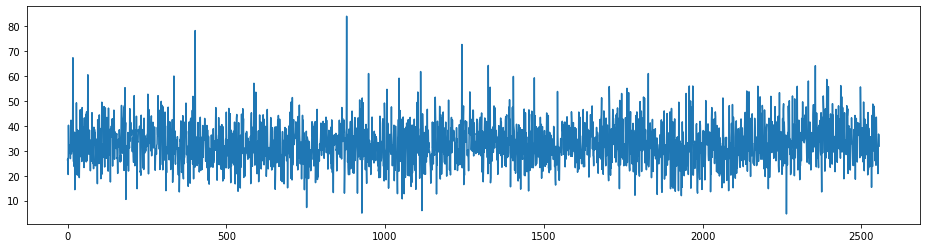

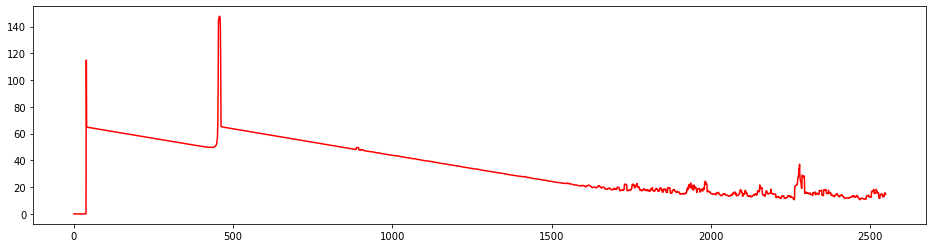

In [225]:
ts_score1 = findChangePoints(duration_arr, r = 0.01, order = 9, smooth = 15)

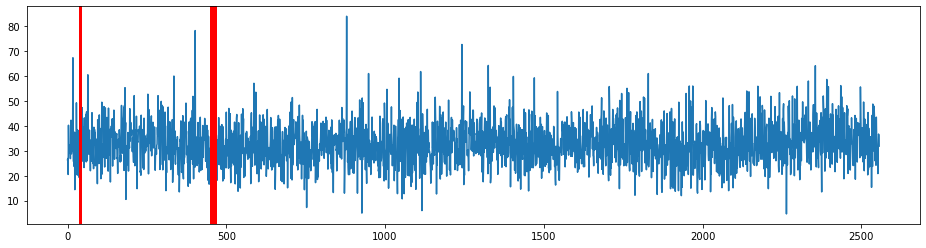

In [226]:
ts_change_loc1 = pd.Series(ts_score1).nlargest(20)
ts_change_loc1 = ts_change_loc1.index
ts_change_loc1
def plot_change_points(ts,ts_change_loc):
    plt.figure(figsize=(16,4))
    plt.plot(ts)
    for x in ts_change_loc:
        plt.axvline(x,lw=2, color='red')
        
plot_change_points(duration_arr,ts_change_loc1)

# Clearance time prediction

In [134]:
column_clear = ['Facility','Incident Type', 'Direction','County', 'Year', 'TOD', 'PeakHour',
       'DayofWeek', 'MonthofYear', 'Injury involved', 'Truck involved','Lane Closure Type',
       'Fire involved', 'Duration (min)']# 
data_clear = data[column_clear]
data_clear = data_clear.dropna()
#data_clear = data_clear[data_clear['Incident Type']==0]
data_clear.to_csv('incident_nyc_clearance.csv')

In [135]:
data_clear['Incident Type'].unique()

array([0, 3, 2, 5, 4, 1])

In [84]:
#Load csv file as a stream
stream_clear = FileStream('incident_nyc_clearance.csv')

# Read crash and disable data

In [21]:
crash = pd.read_csv('crash_nyc.csv').reset_index().iloc[:,1:]
disable = pd.read_csv('disable_nyc.csv').reset_index().iloc[:,1:]
#crash['Duration_class']=pd.qcut(crash['Duration (min)'], 43, labels=False)
#disable['Duration_class']=pd.qcut(disable['Duration (min)'], 43, labels=False)
crash['Duration_class'] = pd.cut(crash['Duration (min)'], [0,30,60,90,120,220], right=True, labels=[1,2,3,4,5])
disable['Duration_class'] = pd.cut(disable['Duration (min)'], [0,30,60,90,120,220], right=True, labels=[1,2,3,4,5])
# crash['Duration_class'] = pd.cut(crash['Duration (min)'], [0,10,20,30,60,220], right=True, labels=[0,1,2,3,4])
# disable['Duration_class'] = pd.cut(disable['Duration (min)'], [0,10,20,30,60,220], right=True, labels=[0,1,2,3,4])


crash['Duration_encode'] = LabelEncoder().fit_transform(crash['Duration (min)'])
disable['Duration_encode'] = LabelEncoder().fit_transform(disable['Duration (min)'])

column_clear = ['Direction','County', 'Year', 'TOD', 'PeakHour',
       'DayofWeek', 'MonthofYear', 'Injury involved', 'Truck involved','Lane Closure Type',
       'Fire involved', 'Duration_class']

crash_withtime = pd.read_csv('crash_nyc.csv').reset_index().iloc[:,1:]
disable_withtime = pd.read_csv('disable_nyc.csv').reset_index().iloc[:,1:]

crash = crash[column_clear]
disable = disable[column_clear]
crash
disable

,Direction,County,Year,TOD,PeakHour,DayofWeek,MonthofYear,Injury involved,Truck involved,Lane Closure Type,Fire involved,Duration_class
0,1,2,0,0,1,0,2,0,0,1,1,2
1,4,3,0,0,1,0,2,0,0,1,0,1
2,3,0,0,0,1,0,2,0,0,1,0,1
3,4,3,0,0,0,0,2,0,0,1,0,2
4,3,3,0,0,0,0,2,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
31378,2,0,6,0,1,0,2,0,0,2,0,2
31379,3,3,6,0,1,0,2,0,0,2,1,5
31380,1,0,6,0,0,0,2,0,0,2,0,1
31381,1,1,6,0,0,0,2,0,0,1,0,1


# Bayesian Networks

In [151]:
from pgmpy.estimators import BDeuScore, K2Score, BicScore,HillClimbSearch
from pgmpy.estimators import BayesianEstimator
from pgmpy.models import BayesianModel
import bnlearn as bn

In [152]:
input_data_crash = pd.read_csv('crash_nyc.csv')
pretrain = input_data_crash[input_data_crash['Year']==0].reset_index()

In [153]:
column_clear = ['Direction','County', 'Year', 'TOD', 'PeakHour',
       'DayofWeek', 'MonthofYear', 'Injury involved', 'Truck involved','Lane Closure Type',
       'Fire involved', 'Duration (min)']
pretrain = pretrain[column_clear]

# XGBoost 

In [154]:
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,accuracy_score


In [155]:
# input_col = ['Direction', 'County',
#     'Year', 'Lane Closure Type', 'TOD', 'PeakHour',
#        'DayofWeek', 'MonthofYear', 'Injury involved', 'Truck involved',
#        'Fire involved']
# output_col = ['Duration (min)']

In [156]:
input_col = ['Direction', 'County', 'Lane Closure Type', 'TOD', 'PeakHour',
       'DayofWeek', 'MonthofYear', 'Injury involved', 'Truck involved',
       'Fire involved']
output_col = ['Duration_class']

In [157]:
# df_input = input_data_crash[input_col]
# df_output = input_data_crash[output_col]
# # Splitting the samples
# X_train, X_rem, y_train, y_rem = train_test_split(df_input, df_output, train_size=0.9, random_state=55)
# X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=55)

# training_data = {'X_train':X_train,'Y_train':y_train,
#                 'X_val': X_val,'Y_val':y_val,
#                 'X_test': X_test,'Y_test':y_test}

In [158]:
crash_pretrain = crash[crash['Year']==0]
df_input = crash_pretrain[input_col]
df_output = crash_pretrain[output_col]
test_input = crash[input_col]

In [159]:
xgb_class = XGBClassifier(n_estimators=1000,learning_rate=0.1,max_depth=6,scale_pos_weight=80)
xgb_class.fit(df_input, df_output)
predicted=xgb_class.predict(test_input)

[14:29:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:29:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [240]:
crash_onetime = copy.deepcopy(crash)

In [241]:
#predict based on each month
crash_onetime['Pred_Duration'] = predicted
#crash['Pred_Score'] = [accuracy_score(i,j) for i,j in zip(list(crash['Duration_class']), predicted)]
crash_onetime['timestamp'] = crash_withtime['Start Date Time']

In [245]:
#crash_test = crash_onetime[crash_onetime['Year']!=0]
crash_test = crash_onetime
crash_test['Month'] = [i.month for i in pd.to_datetime(crash_test['timestamp'])]
acc_onetime = []

for y in np.arange(1,7):
    for m in np.arange(1,13):
        obslist = crash_test[(crash_test['Year']==y) & (crash_test['Month']==m)]['Duration_class']
        predlist = crash_test[(crash_test['Year']==y) & (crash_test['Month']==m)]['Pred_Duration']
        acc_onetime.append(accuracy_score(obslist, predlist))
    
    

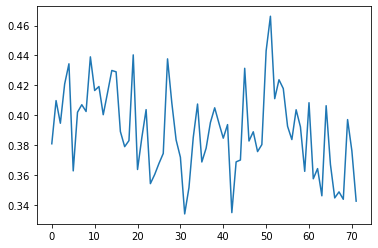

In [246]:
acc_onetime
plt.plot(acc_onetime)

In [249]:
crash

,Direction,County,Year,TOD,PeakHour,DayofWeek,MonthofYear,Injury involved,Truck involved,Lane Closure Type,Fire involved,Duration_class
0,3,0,0,1,0,0,2,0,0,3,0,1
1,1,2,0,1,0,0,2,0,0,1,0,3
2,0,3,0,1,0,0,2,0,0,3,0,4
3,3,0,0,1,0,0,2,0,0,2,0,2
4,1,1,0,1,0,0,2,0,0,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
48823,1,1,6,0,0,0,2,0,0,1,0,1
48824,1,2,6,0,1,0,2,0,0,2,0,1
48825,1,2,6,0,1,0,2,0,0,3,0,1
48826,3,0,6,0,1,0,2,0,0,2,0,3


# Adaptive training stage

In [299]:
crash['timestamp'] = pd.to_datetime(crash_withtime['Start Date Time'])

In [371]:
crash_pretrain = crash[crash['timestamp']<datelist[result[4]-1]]
#crash_pretrain = crash[(crash['timestamp']>=datelist[11])&(crash['timestamp']<datelist[result[0]-1])]
#crash_pretrain = crash[(crash['timestamp']>=datelist[result[0]-1])&(crash['timestamp']<datelist[result[0]+2])]
df_input = crash_pretrain[input_col]
df_output = crash_pretrain[output_col]
# test_input = crash[(crash['timestamp']>=datelist[result[0]-1]) & (crash['timestamp']<datelist[result[1]-1])][input_col]
# test_output = crash[(crash['timestamp']>=datelist[result[0]-1]) & (crash['timestamp']<datelist[result[1]-1])][output_col]
test_input = crash[input_col]



In [372]:
result
test_input

,Direction,County,Lane Closure Type,TOD,PeakHour,DayofWeek,MonthofYear,Injury involved,Truck involved,Fire involved
0,3,0,3,1,0,0,2,0,0,0
1,1,2,1,1,0,0,2,0,0,0
2,0,3,3,1,0,0,2,0,0,0
3,3,0,2,1,0,0,2,0,0,0
4,1,1,2,1,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...
48823,1,1,1,0,0,0,2,0,0,0
48824,1,2,2,0,1,0,2,0,0,0
48825,1,2,3,0,1,0,2,0,0,0
48826,3,0,2,0,1,0,2,0,0,0


In [373]:
xgb_class = XGBClassifier(n_estimators=1000,learning_rate=0.1,max_depth=6,scale_pos_weight=80)
xgb_class.fit(df_input, df_output)
predicted=xgb_class.predict(test_input)

[20:26:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:26:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [374]:
crash_adapt = copy.deepcopy(crash)

In [375]:
#predict based on each month
crash_adapt['Pred_Duration'] = predicted
#crash['Pred_Score'] = [accuracy_score(i,j) for i,j in zip(list(crash['Duration_class']), predicted)]
crash_adapt['timestamp'] = crash_withtime['Start Date Time']

In [376]:
#crash_test = crash_onetime[crash_onetime['Year']!=0]
crash_test = crash_adapt
crash_test['Month'] = [i.month for i in pd.to_datetime(crash_test['timestamp'])]
acc_adapt = []

for y in np.arange(1,7):
    for m in np.arange(1,13):
        obslist = crash_test[(crash_test['Year']==y) & (crash_test['Month']==m)]['Duration_class']
        predlist = crash_test[(crash_test['Year']==y) & (crash_test['Month']==m)]['Pred_Duration']
        acc_adapt.append(accuracy_score(obslist, predlist))
    

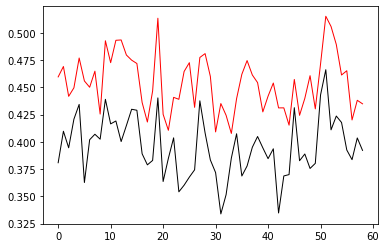

In [377]:
acc_adapt[:59]
acc_onetime[:59]
plt.plot(acc_onetime[:59],color="black",linewidth=1)
plt.plot(acc_adapt[:59],color="red",linewidth=1)

# acc_diff = np.asarray(acc_adapt)-np.asarray(acc_onetime)
# plt.plot(acc_diff[:44]*100)

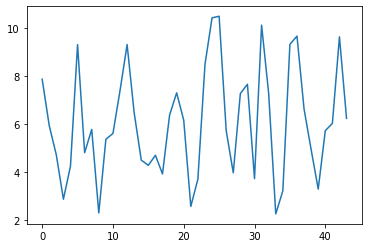

In [378]:
acc_diff = np.asarray(acc_adapt)-np.asarray(acc_onetime)
plt.plot(acc_diff[:44]*100)

In [340]:
acc_diff_1 = acc_diff.copy() #30-45

In [351]:
acc_diff_2 = acc_diff.copy() #45-60

In [361]:
acc_diff_3 = acc_diff.copy() #60-65

In [370]:
acc_diff_4 = acc_diff.copy() #65-75

In [379]:
acc_diff_5 = acc_diff.copy() #75-84

In [352]:
result

[30, 45, 60, 65, 75, 84]

In [386]:
update_acc_diff = []
update_acc_diff.append(acc_diff_1[29-12:44-12])
update_acc_diff.append(acc_diff_2[44-12:59-12])
update_acc_diff.append(acc_diff_3[59-12:64-12])
update_acc_diff.append(acc_diff_4[64-12:74-12])
update_acc_diff.append(acc_diff_5[74-12:83-12])

In [395]:
update_acc_diff = list(acc_diff_1[29-12:44-12])+list(acc_diff_2[44-12:59-12])+list(acc_diff_3[59-12:64-12])+list(acc_diff_4[64-12:74-12])+list(acc_diff_5[74-12:83-12])

In [30]:
# update_acc_diff

In [83]:
# Machine Learning Model

#xgb=XGBRegressor(n_estimators=1000,learning_rate=0.1,max_depth=6,scale_pos_weight=80)
xgb=XGBRegressor(n_estimators = 1000, n_jobs=-1, verbose=2, criterion="mae", max_depth=6, min_samples_split=3, max_samples=100)

#rf=XGBClassifier(param)
xgb.fit(X_train, y_train)
predicted=xgb.predict(X_test)

# Finding RMSE
rmse=mean_squared_error(y_test, predicted, squared=False)
mae=mean_absolute_error(y_test, predicted)
mape = mean_absolute_percentage_error(y_test, predicted)
print(mape)

[07:36:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { criterion, max_samples, min_samples_split, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


1.2112757855679699


In [92]:
input_data_crash[input_data_crash['Year']==0]
input_data_crash
data_clear = pd.read_csv('incident_nyc_clearance.csv')
data_clear

,Unnamed: 0,Facility,Incident Type,Direction,County,Year,TOD,PeakHour,DayofWeek,MonthofYear,Injury involved,Truck involved,Lane Closure Type,Fire involved,Duration (min)
0,0,268,0,5,2,0,1,0,0,2,0,0,3,0,22.0
1,1,268,3,3,2,0,1,0,0,2,0,0,2,0,12.0
2,4,301,0,5,2,0,1,0,0,2,0,0,2,0,42.0
3,5,321,0,2,1,0,1,0,0,2,0,0,2,0,36.0
4,7,286,0,2,3,0,1,0,0,2,0,0,1,0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65011,96407,321,0,2,1,6,0,0,0,2,0,0,1,0,10.0
65012,96408,330,0,2,3,6,0,1,0,2,0,0,2,0,15.0
65013,96409,330,0,2,3,6,0,1,0,2,0,0,3,0,5.0
65014,96411,341,2,3,0,6,0,1,0,2,0,0,2,0,30.0


# Adaptive Random Forest

In [101]:
#Load csv file as a stream
stream_clear = FileStream('incident_nyc_clearance.csv')
data_clear = pd.read_csv('incident_nyc_clearance.csv')

In [94]:
# Example code

# Prepare stream for use
# Setup the Adaptive Random Forest regressor
arf_reg = AdaptiveRandomForestRegressor(random_state=123456)
# Auxiliary variables to control loop and track performance
n_samples = 0
max_samples = 20000
y_pred = np.zeros(max_samples)
y_true = np.zeros(max_samples)
# Run test-then-train loop for max_samples and while there is data
while n_samples < max_samples and stream_clear.has_more_samples():
    X, y = stream_clear.next_sample()
    y_true[n_samples] = y[0]
    y_pred[n_samples] = arf_reg.predict(X)[0]
    arf_reg.partial_fit(X, y)
    n_samples += 1
# Display results
print('Adaptive Random Forest regressor example')
print('{} samples analyzed.'.format(n_samples))
print('Mean absolute error: {}'.format(np.mean(np.abs(y_true - y_pred))))

Adaptive Random Forest regressor example
20000 samples analyzed.
Mean absolute error: 13.938745879558127


In [109]:
data_clear[data_clear['Duration (min)']==6]

,Unnamed: 0,Facility,Incident Type,Direction,County,Year,TOD,PeakHour,DayofWeek,MonthofYear,Injury involved,Truck involved,Lane Closure Type,Fire involved,Duration (min)
8,12,495,2,3,0,0,0,1,0,2,0,0,1,0,6.0
69,92,330,0,2,3,0,0,1,0,2,0,0,1,0,6.0
86,115,150,0,2,2,0,0,1,0,2,0,0,1,0,6.0
141,202,335,2,5,3,0,0,0,0,2,0,0,1,0,6.0
273,395,335,2,3,3,0,0,1,0,2,0,0,1,0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64745,95987,434,2,6,4,6,0,0,1,2,0,0,1,0,6.0
64755,96006,385,2,6,2,6,0,1,1,2,0,1,3,0,6.0
64785,96056,330,0,2,3,6,0,1,0,2,0,0,1,0,6.0
64977,96355,321,0,6,1,6,1,0,0,2,0,0,2,0,6.0


In [105]:
mean_absolute_error(y_pred, y_true)

13.938745879558127

In [195]:
# 3. Setup the evaluator
evaluator = EvaluatePrequential(show_plot=True,
                                pretrain_size=2000,
                                max_samples=20000, metrics=['mean_absolute_error'])
# 4. Run evaluation
evaluator.evaluate(stream=stream_clear, model=arf_reg)

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 ######-------------- [30%] [78.61s]

/opt/anaconda3/lib/python3.8/site-packages/skmultiflow/trees/nodes/active_learning_node_perceptron.py:127: RuntimeWarning: overflow encountered in long_scalars
  a = square_val - ((val * val) / size)


 #################### [100%] [269.73s]
Processed samples: 20000
Mean performance:
M0 - MAE          : 13.929756


[AdaptiveRandomForestRegressor(aggregation_method='median', binary_split=False,
                               drift_detection_criteria='mse',
                               drift_detection_method=ADWIN(delta=0.001),
                               grace_period=50, lambda_value=6,
                               leaf_prediction='perceptron',
                               learning_ratio_const=True,
                               learning_ratio_decay=0.001,
                               learning_ratio_perceptron=0.1,
                               max_byte_size=1048576000, max_features=4,
                               memory_estimate_period=2000000, n_estimators=10,
                               no_preprune=False, nominal_attributes=None,
                               random_state=123456, remove_poor_atts=False,
                               split_confidence=0.01, stop_mem_management=False,
                               tie_threshold=0.05,
                               warning_dete

In [83]:
# The second example demonstrates how to compare two models
from skmultiflow.data import SEAGenerator
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.bayes import NaiveBayes
from skmultiflow.evaluation import EvaluateHoldout
# Set the stream
stream = SEAGenerator(random_state=1)
# Set the models
ht = HoeffdingTreeClassifier()
nb = NaiveBayes()
evaluator = EvaluatePrequential(max_samples=10000,
                                max_time=1000,
                                show_plot=True,
                                metrics=['accuracy', 'kappa'])
# Run evaluation
evaluator.evaluate(stream=stream, model=[ht, nb], model_names=['HT', 'NB'])

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [2.77s]
Processed samples: 10000
Mean performance:
HT - Accuracy     : 0.9611
HT - Kappa        : 0.9091
NB - Accuracy     : 0.9402
NB - Kappa        : 0.8555


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05),
 NaiveBayes(nominal_attributes=None)]

In [149]:
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
from imblearn.over_sampling import SMOTE


data_clear = crash_ann#data_clear[data_clear['Year']==5]

df_input = data_clear.iloc[:,:-1]
df_output = data_clear.iloc[:,-1]

In [150]:
# Splitting the samples
X_train, X_rem, y_train, y_rem = train_test_split(df_input, df_output, train_size=0.8, random_state=55)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=55)

training_data = {'X_train':X_train,'Y_train':y_train,
                'X_val': X_val,'Y_val':y_val,
                'X_test': X_test,'Y_test':y_test}

In [152]:
#initial version of xgboost

# Splitting the samples
X_train, X_test, y_train, y_test = train_test_split(df_input, df_output, test_size=0.33, random_state=55)
#Resampling to avoid imbalance
# sm = SMOTE(random_state = 52)
# X_train, y_train = sm.fit_resample(X_train, y_train)

# Machine Learning Model
#xgb=XGBRegressor(n_estimators=1000,learning_rate=0.1,max_depth=6,scale_pos_weight=80)
xgb=XGBRegressor(n_estimators = 1000, n_jobs=-1, max_depth=5, min_samples_split=3, max_samples=1000)

#rf=XGBClassifier(param)
xgb.fit(X_train, y_train)
predicted=xgb.predict(X_test)

# Finding RMSE

# def MAPE(Y_actual,Y_Predicted):
#     mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
#     return mape

rmse=mean_squared_error(y_test, predicted, squared=False)
mae=mean_absolute_error(y_test, predicted)
mape = mean_absolute_percentage_error(y_test, predicted)
print(mae)
print(mape)

[15:23:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { max_samples, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


29.39582155664313
1.232184862260499


In [159]:
a = [1,3]
b=[2]
c = sorted(a+b)
c
(3+4)//2

3

# ANN

In [77]:
from numpy import vstack
from numpy import sqrt
from pandas import read_csv
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import MSELoss
from torch.nn.init import xavier_uniform_
import torch.nn as nn
import torch
import torch.utils.data as utils
import torch.nn.functional as F

In [63]:
class ANNModel_pred(nn.Module):

    def __init__(self, input_size, output_size, layers, p=0.4):
        super().__init__()

        all_layers = []

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x):
        x = self.layers(x)
        return x

In [144]:
# dataset definition
class PrepareDataset(Dataset):
    # load the dataset
    def __init__(self, df):
        # store the inputs and outputs
        self.X = df.iloc[:, :-1].values.astype('float32')
        self.y = df.iloc[:, -1].values.astype('float32')
        # ensure target has the right shape
        self.y = self.y.reshape((len(self.y), 1))

    # number of rows in the dataset
    def __len__(self):
        return len(self.X)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    # get indexes for train and test rows
    def get_splits(self, n_test=0.33):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size],generator=torch.Generator().manual_seed(0))


# model definition
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 200)
        xavier_uniform_(self.hidden1.weight)
        self.act1 = Sigmoid()
        # second hidden layer
        self.hidden2 = Linear(200, 50)
        xavier_uniform_(self.hidden2.weight)
        self.act2 = Sigmoid()
        # third hidden layer and output
        self.hidden3 = Linear(50, 1)
        xavier_uniform_(self.hidden3.weight)

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
         # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # third hidden layer and output
        X = self.hidden3(X)
        return X

# prepare the dataset
def prepare_data(path):
    # load the dataset
    dataset = PrepareDataset(path)
    # calculate split
    train, test = dataset.get_splits()
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    return train_dl, test_dl

# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = MSELoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    # enumerate epochs
    for epoch in range(100):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate mse
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    mape = mean_absolute_percentage_error(actuals, predictions)
    return mse, mae, mape

# # make a class prediction for one row of data
# def predict(row, model):
#     # convert row to data
#     row = Tensor([row])
#     # make prediction
#     yhat = model(row)
#     # retrieve numpy array
#     yhat = yhat.detach().numpy()
#     return yhat

# prepare the data
path = 'incident_nyc_clearance.csv'
train_dl, test_dl = prepare_data(crash_ann)
print(len(train_dl.dataset), len(test_dl.dataset))
# define the network
model = MLP(crash_ann.shape[1]-1)
#model = ANNModel_pred(data_clear.shape[1]-1,1, [20,50,100,200,300], p=0.4)
#model = ANNModel(cat_embedding_pred_sizes, len(num_col_pred), 1, [50,100,200,300], p=0.5)
# train the model
train_model(train_dl, model)
# evaluate the model
acc = evaluate_model(test_dl, model)
print('Accuracy: %.3f' % acc[2])
# make a single prediction
# row = [5.1,3.5,1.4,0.2]
# yhat = predict(row, model)
# print('Predicted: %s (class=%d)' % (yhat, argmax(yhat)))

32715 16113
Accuracy: 1.015


In [199]:
class MLP(Module):
    #define parameter
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        #first hidden layer
        self.hidden1 = Linear(n_inputs, 500)
        xavier_uniform_(self.hidden1.weight)
        self.act1 = Sigmoid()
        #second hidden layer
        self.hidden2 = Linear(500, 300)
        xavier_uniform_(self.hidden2.weight)
        self.act2 = Sigmoid()
        #third hidden layer
        self.hidden3 = Linear(300, 100)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Sigmoid()
        #fourth hidden layer
        self.hidden4 = Linear(100,1)
        xavier_uniform_(self.hidden4.weight)

    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.hidden3(X)
        X = self.act3(X)
        X = self.hidden4(X)
        X = F.dropout(X, 0.5, training=self.training)
        return X
    
class PrepareDataset(Dataset):
    def __init__(self, path):
        self.column = ['Start Date Time','Direction','County','TOD', 'PeakHour',
   'DayofWeek', 'MonthofYear', 'Injury involved', 'Truck involved','Lane Closure Type',
   'Fire involved', 'Duration (min)']
        self.data = pd.read_csv(path).reset_index().iloc[:,1:][self.column]
        self.data = self.data[self.data['Duration (min)']<=30]
        self.data['Start Date Time'] = pd.to_datetime(self.data['Start Date Time'])
    def get_split(self,starttime, endtime):
        train_data = self.data[self.data['Start Date Time']<=starttime].drop('Start Date Time', axis=1)
        test_data = self.data[(self.data['Start Date Time']>starttime) & (self.data['Start Date Time']<=endtime)].drop('Start Date Time', axis=1)
        train_seq, train_label = train_data.iloc[:,:-1].values.astype('float32'), train_data.iloc[:,-1].values.astype('float32')
        test_seq, test_label = test_data.iloc[:,:-1].values.astype('float32'), test_data.iloc[:,-1].values.astype('float32')
        train_seq, train_label = np.asarray(train_seq), np.asarray(train_label)
        test_seq, test_label = np.asarray(test_seq), np.asarray(test_label)
        
        train_seq, train_label = torch.Tensor(train_seq), torch.Tensor(train_label)
        test_seq, test_label = torch.Tensor(test_seq), torch.Tensor(test_label)
        
        train_dataset = utils.TensorDataset(train_seq, train_label)
        test_dataset = utils.TensorDataset(test_seq, test_label)
        
        train_dl = utils.DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_dl = utils.DataLoader(test_dataset, batch_size=64, shuffle=False)
        
        return train_dl, test_dl

def train_model(train_dl, model):
    #define optimization
    criterion = MSELoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    #enumerate epochs
    for i, (inputs, targets) in enumerate(train_dl):
        #clear the gradients
        optimizer.zero_grad()
        #compute the model output
        yhat = model(inputs)
        #calculate training loss
        loss = criterion(yhat, targets)
        #credit assignment
        loss.backward()
        #update model weights
        optimizer.step()

# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate mse
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    mape = mean_absolute_percentage_error(actuals, predictions)
    return mse, mae, mape

            
# prepare the data
path = 'crash_nyc.csv'

dataset = PrepareDataset(path)

start = pd.Timestamp(2018,1,1,0)

end = pd.Timestamp(2019,1,1,0)

train_dl, test_dl = dataset.get_split(start, end)
inputs, target = next(iter(train_dl))

print(len(train_dl.dataset), len(test_dl.dataset))
# define the network
model = MLP(inputs.size(1))
#model = ANNModel_pred(data_clear.shape[1]-1,1, [20,50,100,200,300], p=0.4)
#model = ANNModel(cat_embedding_pred_sizes, len(num_col_pred), 1, [50,100,200,300], p=0.5)
# train the model
train_model(train_dl, model)
# evaluate the model
acc = evaluate_model(test_dl, model)
print('Accuracy: %.3f' % acc[2])    
        

8557 2933
Accuracy: 0.764


In [70]:
start = pd.Timestamp(2016,1,1,0)
start

Timestamp('2017-01-01 00:00:00')

In [67]:
acc[0]

1730.846

In [143]:
column_ann = ['Direction','County', 'TOD', 'PeakHour',
       'DayofWeek', 'MonthofYear', 'Injury involved', 'Truck involved','Lane Closure Type',
       'Fire involved', 'Duration (min)']
crash_ann = pd.read_csv('crash_nyc.csv').reset_index().iloc[:,1:][column_ann]
crash_ann

,Direction,County,TOD,PeakHour,DayofWeek,MonthofYear,Injury involved,Truck involved,Lane Closure Type,Fire involved,Duration (min)
0,3,0,1,0,0,2,0,0,3,0,22.0
1,1,2,1,0,0,2,0,0,1,0,65.0
2,0,3,1,0,0,2,0,0,3,0,110.0
3,3,0,1,0,0,2,0,0,2,0,42.0
4,1,1,1,0,0,2,0,0,2,0,36.0
...,...,...,...,...,...,...,...,...,...,...,...
48823,1,1,0,0,0,2,0,0,1,0,10.0
48824,1,2,0,1,0,2,0,0,2,0,15.0
48825,1,2,0,1,0,2,0,0,3,0,5.0
48826,3,0,0,1,0,2,0,0,2,0,68.0
